In [14]:
%pip install xgboost

                                              0.0/150.0 MB ? eta -:--:--
                                             1.4/150.0 MB 45.9 MB/s eta 0:00:04
     -                                       4.0/150.0 MB 51.1 MB/s eta 0:00:03
     -                                       7.2/150.0 MB 57.8 MB/s eta 0:00:03
     --                                     10.4/150.0 MB 65.6 MB/s eta 0:00:03
     ---                                    13.0/150.0 MB 65.6 MB/s eta 0:00:03
     ---                                    15.3/150.0 MB 65.6 MB/s eta 0:00:03
     ----                                   18.3/150.0 MB 59.5 MB/s eta 0:00:03
     -----                                  21.2/150.0 MB 59.5 MB/s eta 0:00:03
     ------                                 24.3/150.0 MB 65.6 MB/s eta 0:00:02
     ------                                 27.3/150.0 MB 65.2 MB/s eta 0:00:02
     -------                                29.7/150.0 MB 65.6 MB/s eta 0:00:02
     --------                               33.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
import matplotlib.pyplot as plt

c:\Users\juank\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [6]:
df = pd.read_parquet('filtered_base.parquet')

In [7]:
df.rename(columns={'NBS_mORA' : 'NBS_mora'}, inplace = True)

In [8]:
df

,dias_mora,Estado_Inicial,Plan_Agrupado,Ant_pol,NBS,Huerfano,MedioPago,activos,genero,Edad,Juridico,total_mora,NBS_mora,Total_Activas,NBS_Vigente,Estado_Final_2_meses_despues,efectivo_disponible
0,17,0,Vida Entera,317,1198163,1,MANUAL,0.0,F,78,0,1,1198163,1,1198163,0,0.0
1,-22,0,AP,314,364493,1,AUTOMATICO,80000000.0,F,63,0,3,5250399,3,5250399,0,6200000.0
2,-14,0,AP,299,696918,1,AUTOMATICO,0.0,M,63,0,1,696918,1,662470,0,0.0
3,0,0,AP,295,695639,0,AUTOMATICO,0.0,F,56,0,1,695639,1,695639,1,0.0
4,-14,0,AP,295,1391279,1,AUTOMATICO,1000000000.0,M,58,0,6,23168963,7,103481172,0,179569000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80881,32,0,PUF,6,6111496,0,AUTOMATICO,261485000.0,F,38,0,2,10587675,2,10587675,0,106388988.0
80882,-30,0,PUF,6,5486643,0,AUTOMATICO,258752000.0,F,45,0,1,5486643,1,5486643,0,186789996.0
80883,-30,0,Vida Entera,6,7200288,0,AUTOMATICO,24028754.0,M,64,0,1,7200288,1,7200288,0,1010567004.0
80884,1,0,PUF,6,5490099,0,AUTOMATICO,420000000.0,F,42,0,3,13680346,4,14506596,0,122352288.0


Separar X y Y

In [9]:
y = df['Estado_Final_2_meses_despues'] 
X = df.drop(columns=['Estado_Final_2_meses_despues'])

Escalar numericas y obtener Dummies de las categoricas (que aun no son 1-0)
correr otra vez este ejercicio sin activos y efectivo

In [10]:
num_cols = ['dias_mora','Ant_pol', 'NBS',  'Edad', 'total_mora', 'NBS_mora','Total_Activas', 'NBS_Vigente']
cat_cols = ['Plan_Agrupado', 'MedioPago', 'genero']

In [11]:
df.dtypes

dias_mora                                Int64
Estado_Inicial                           int32
Plan_Agrupado                   string[python]
Ant_pol                                  Int64
NBS                                      Int64
Huerfano                                 Int64
MedioPago                               object
activos                                Float64
genero                                  object
Edad                                     Int64
Juridico                                 Int64
total_mora                               Int64
NBS_mora                                 Int64
Total_Activas                            Int64
NBS_Vigente                              Int64
Estado_Final_2_meses_despues             int32
efectivo_disponible                    Float64
dtype: object

In [12]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),         
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)

Crear Pipeline para probar varios modelos con previa transformacion

In [13]:
base_pipe = Pipeline(steps=[("prep", preprocess),
                            ("clf", None)]) 

Diccionario de modelos y parametros a probar

In [30]:
models_and_grids = {
    "logistic_regression": (
        LogisticRegression(max_iter=200, class_weight="balanced", solver="lbfgs"),
        {
            "clf__C": [0.01, 0.05, 0.1,0.5, 1,5, 10]
        }
    ),
    "random_forest": (
        RandomForestClassifier(class_weight="balanced"),
        {
            "clf__max_depth": [10, 20, 30],
            "clf__min_samples_split": [2, 10],
            "clf__n_estimators": [100,200,300]
        }
    ),
    "adaboost": (
        AdaBoostClassifier(),
        {
            "clf__learning_rate": [0.01,0.05, 0.1,0.5, 1.0],
            "clf__n_estimators": [100,200,300],
        }
    ),
    "xgboost": (
        xgb.XGBClassifier(
            objective="binary:logistic",
            eval_metric="aucpr",
            scale_pos_weight=(y.value_counts()[0] / y.value_counts()[1])
        ),
        {

            "clf__max_depth": [3, 5, 7],
            "clf__learning_rate": [0.01, 0.05, 0.1],
            "clf__subsample": [0.6, 1.0],
            "clf__colsample_bytree": [0.6, 1.0],

        }
    )
}

Train Test Split estratificado

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

Loop para correr los modelos, hacemos un gridsearch con un 3 kfolds estratificados y escogemos el mejor parametro para cada uno de nuestros modelos
Usamos de scorer ROC_AUC para predecir correctamente los cancelados pero no permitir tampoco una gran cantidad de falsos positivos

In [40]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
best_models = {}


In [41]:
for name, (model, param_grid) in models_and_grids.items():
    print(f"Entrenando Modelo: {name.upper()}")
    pipe = base_pipe.set_params(clf=model)
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=cv,
        scoring="f1",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Mejor metrica: {grid.best_score_:.3f}")
    print(f"Mejores Parametros: {grid.best_params_}")

Entrenando Modelo: LOGISTIC_REGRESSION
Fitting 3 folds for each of 7 candidates, totalling 21 fits
Mejor metrica: 0.199
Mejores Parametros: {'clf__C': 0.01}
Entrenando Modelo: RANDOM_FOREST
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Mejor metrica: 0.436
Mejores Parametros: {'clf__max_depth': 20, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}
Entrenando Modelo: ADABOOST
Fitting 3 folds for each of 15 candidates, totalling 45 fits


c:\Users\juank\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Mejor metrica: 0.160
Mejores Parametros: {'clf__learning_rate': 1.0, 'clf__n_estimators': 300}
Entrenando Modelo: XGBOOST
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Mejor metrica: 0.413
Mejores Parametros: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__subsample': 0.6}


In [42]:
best_models

{'logistic_regression': Pipeline(steps=[('prep',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['dias_mora', 'Ant_pol',
                                                    'NBS', 'Edad', 'total_mora',
                                                    'NBS_mora', 'Total_Activas',
                                                    'NBS_Vigente']),
                                                  ('cat',
                                                   OneHotEncoder(handle_unknown='ignore'),
                                                   ['Plan_Agrupado', 'MedioPago',
                                                    'genero'])])),
                 ('clf',
                  LogisticRegression(C=0.01, class_weight='balanced',
                                     max_iter=200))]),
 'random_forest': Pipeline(steps=[('prep',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
 

Resultados sin alterar tresholds

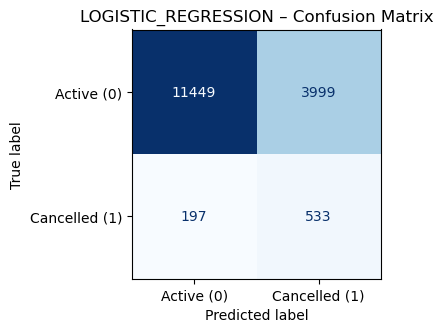


LOGISTIC_REGRESSION – classification report (threshold = 0.50)

               precision    recall  f1-score   support

   Active (0)      0.983     0.741     0.845     15448
Cancelled (1)      0.118     0.730     0.203       730

     accuracy                          0.741     16178
    macro avg      0.550     0.736     0.524     16178
 weighted avg      0.944     0.741     0.816     16178



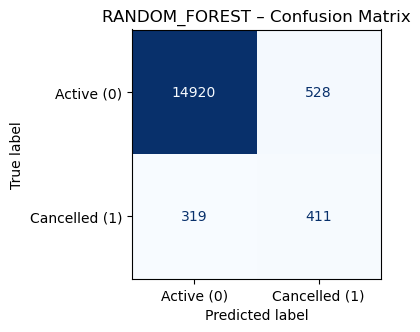


RANDOM_FOREST – classification report (threshold = 0.50)

               precision    recall  f1-score   support

   Active (0)      0.979     0.966     0.972     15448
Cancelled (1)      0.438     0.563     0.493       730

     accuracy                          0.948     16178
    macro avg      0.708     0.764     0.732     16178
 weighted avg      0.955     0.948     0.951     16178



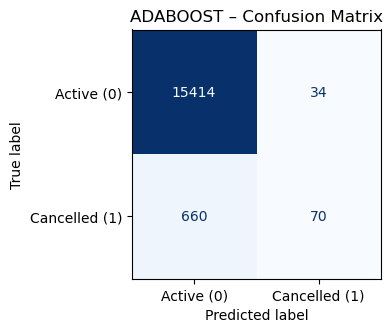


ADABOOST – classification report (threshold = 0.50)

               precision    recall  f1-score   support

   Active (0)      0.959     0.998     0.978     15448
Cancelled (1)      0.673     0.096     0.168       730

     accuracy                          0.957     16178
    macro avg      0.816     0.547     0.573     16178
 weighted avg      0.946     0.957     0.941     16178



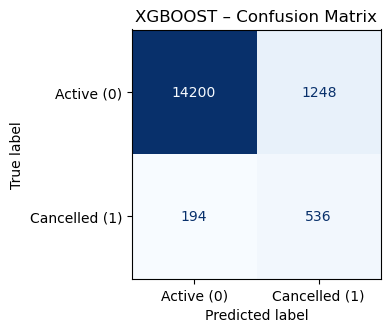


XGBOOST – classification report (threshold = 0.50)

               precision    recall  f1-score   support

   Active (0)      0.987     0.919     0.952     15448
Cancelled (1)      0.300     0.734     0.426       730

     accuracy                          0.911     16178
    macro avg      0.643     0.827     0.689     16178
 weighted avg      0.956     0.911     0.928     16178



In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Optional: write figures to disk so you can drop them into PowerPoint
SAVE_PNG = False            # set True to save each plot

for name, model in best_models.items():
    # ------------- Confusion matrix -------------
    fig, ax = plt.subplots(figsize=(4, 4))
    
    # Default threshold = 0.50.
    # If you tuned a custom threshold, replace `from_estimator` with manual cm.
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=["Active (0)", "Cancelled (1)"],
        cmap="Blues",
        colorbar=False,
        ax=ax
    )
    ax.set_title(f"{name.upper()} – Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.tight_layout()

    if SAVE_PNG:
        fig.savefig(f"{name}_confusion_matrix.png", dpi=300, bbox_inches="tight")

    plt.show()

    # ------------- Classification report -------------
    print(f"\n{name.upper()} – classification report (threshold = 0.50)\n")
    print(classification_report(y_test,
                                model.predict(X_test),
                                target_names=["Active (0)", "Cancelled (1)"],
                                digits=3))

Probar con diferentes tresholds

In [59]:
def best_f1_threshold(y_true, y_proba):
    prec, rec, thr = precision_recall_curve(y_true, y_proba)
    f1 = 2 * prec * rec / (prec + rec + 1e-15)          # F1 for each point
    idx = np.argmax(f1[:-1])                             # last F1 has no thr
    return thr[idx], f1[idx], prec[idx], rec[idx]

thresholds = {}   

for name, model in best_models.items():
    proba_val = model.predict_proba(X_train)[:, 1]   #probabilidad de la clase 1
    thr, f1, p, r = best_f1_threshold(y_train, proba_val)
    thresholds[name] = thr
    print(f"{name:15s}  best f1 = {f1:.3f} best recall {f1:.3f} "
          f"(precision={p:.3f})  at threshold={thr:.3f}")

logistic_regression  best f1 = 0.263 best recall 0.263 (precision=0.177)  at threshold=0.619
random_forest    best f1 = 0.765 best recall 0.765 (precision=0.750)  at threshold=0.616
adaboost         best f1 = 0.432 best recall 0.432 (precision=0.360)  at threshold=0.499
xgboost          best f1 = 0.579 best recall 0.579 (precision=0.527)  at threshold=0.821


In [60]:
thresholds

{'logistic_regression': 0.619289135627764,
 'random_forest': 0.6156712396550819,
 'adaboost': 0.49876936295171964,
 'xgboost': 0.8208004}

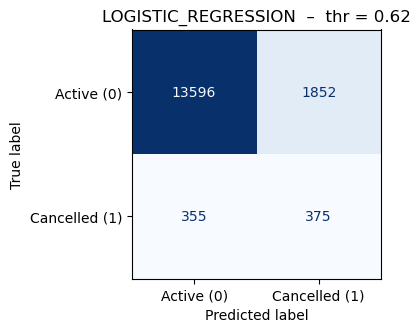


LOGISTIC_REGRESSION  –  classification report (thr = 0.62)

               precision    recall  f1-score   support

   Active (0)      0.975     0.880     0.925     15448
Cancelled (1)      0.168     0.514     0.254       730

     accuracy                          0.864     16178
    macro avg      0.571     0.697     0.589     16178
 weighted avg      0.938     0.864     0.895     16178



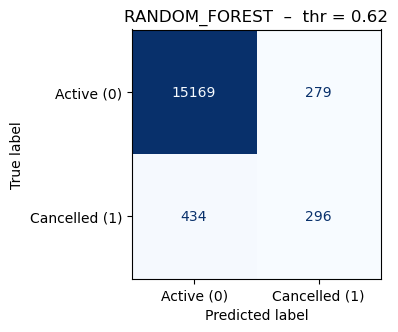


RANDOM_FOREST  –  classification report (thr = 0.62)

               precision    recall  f1-score   support

   Active (0)      0.972     0.982     0.977     15448
Cancelled (1)      0.515     0.405     0.454       730

     accuracy                          0.956     16178
    macro avg      0.743     0.694     0.715     16178
 weighted avg      0.952     0.956     0.953     16178



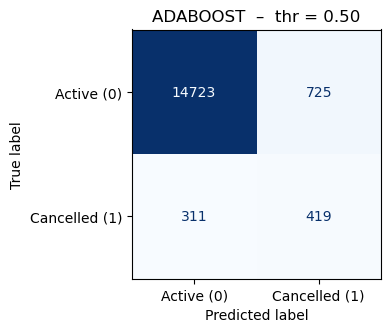


ADABOOST  –  classification report (thr = 0.50)

               precision    recall  f1-score   support

   Active (0)      0.979     0.953     0.966     15448
Cancelled (1)      0.366     0.574     0.447       730

     accuracy                          0.936     16178
    macro avg      0.673     0.764     0.707     16178
 weighted avg      0.952     0.936     0.943     16178



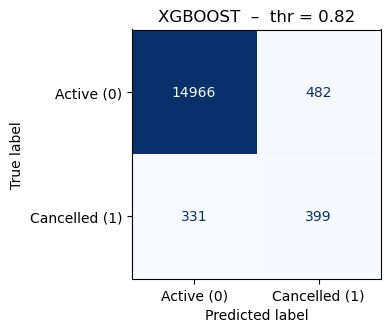


XGBOOST  –  classification report (thr = 0.82)

               precision    recall  f1-score   support

   Active (0)      0.978     0.969     0.974     15448
Cancelled (1)      0.453     0.547     0.495       730

     accuracy                          0.950     16178
    macro avg      0.716     0.758     0.734     16178
 weighted avg      0.955     0.950     0.952     16178



In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

SAVE_PNG = False          # flip to True if you want .png files

for name, est in best_models.items():
    thr = thresholds[name]                      # model-specific cut-off
    
    # ── 1. predict with the custom threshold ──────────────────────────
    proba_test = est.predict_proba(X_test)[:, 1]    # P(y = 1)
    y_pred     = (proba_test >= thr).astype(int)
    
    # ── 2. confusion-matrix figure ────────────────────────────────────
    cm   = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
              confusion_matrix = cm,
              display_labels   = ["Active (0)", "Cancelled (1)"]
           )
    fig, ax = plt.subplots(figsize=(4, 4))
    disp.plot(ax=ax, cmap="Blues", colorbar=False, values_format="d")
    ax.set_title(f"{name.upper()}  –  thr = {thr:.2f}")
    plt.tight_layout()
    
    if SAVE_PNG:
        fig.savefig(f"{name}_cm_thr{thr:.2f}.png", dpi=300, bbox_inches="tight")
    
    plt.show()
    
    # ── 3. classification report ──────────────────────────────────────
    print(f"\n{name.upper()}  –  classification report (thr = {thr:.2f})\n")
    print(
        classification_report(
            y_test,
            y_pred,
            target_names = ["Active (0)", "Cancelled (1)"],
            digits       = 3
        )
    )
